In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from scipy.optimize import minimize
from statsmodels.base.model import GenericLikelihoodModel
%matplotlib inline

### Four Steps in calculating MLE
1. Verify that uniform priors are a safe assumption
2. Define distribution (normal)
3. Define objective function
4. Define likelihood 
5. Take natural log to reduce product to sum
6. Minimize negative of objective function

# n-D example for normal distribution

In [77]:
data = sm.datasets.fair.load_pandas().data
y = data.affairs
X = data[['rate_marriage', 'age', 'yrs_married', 'children', 'religious', 'educ', 'occupation', 'occupation_husb']].copy()
X = sm.add_constant(X)
X.head()

,const,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb
0,1.0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0
1,1.0,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0
2,1.0,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0
3,1.0,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0
4,1.0,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0


In [91]:
class NormMod(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(NormMod, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        beta = params
        yhat = np.dot(self.exog, beta)
        LL = stats.norm.logpdf(self.endog, loc=yhat)
        return -LL
    
    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        if start_params == None:
            start_params = np.zeros(self.exog.shape[1])
            start_params[0] = np.log(self.endog.mean())
        return super(NormMod, self).fit(start_params=start_params,
                                        maxiter=maxiter, maxfun=maxfun,
                                        **kwds)

In [92]:
mod = NormMod(y, X)
res = mod.fit()

Optimization terminated successfully.
         Current function value: 3.252746
         Iterations: 1865
         Function evaluations: 2669


In [93]:
print(res.summary())

                               NormMod Results                                
Dep. Variable:                affairs   Log-Likelihood:                -20707.
Model:                        NormMod   AIC:                         4.143e+04
Method:            Maximum Likelihood   BIC:                         4.149e+04
Date:                Wed, 14 Aug 2019                                         
Time:                        12:11:17                                         
No. Observations:                6366                                         
Df Residuals:                    6357                                         
Df Model:                           8                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.0665      0.124     16.657      0.000       1.823       2.310
rate_marriage      -0.2891      0.013

# n-D example for binomial distribution

In [60]:
def _ll_nb2(y, X, beta, alph):
    mu = np.exp(np.dot(X, beta))
    n = 1 / alph
    p = n / (n + mu)
    ll = stats.nbinom.logpmf(y, n, p)
    return ll

In [57]:
class NBin(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(NBin, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        alph = params[-1]
        beta = params[:-1]
        ll = _ll_nb2(self.endog, self.exog, beta, alph)
        return -ll
    
    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        # add alpha to summary
        self.exog_names.append('alpha')
        if start_params == None:
            start_params = np.append(np.zeros(self.exog.shape[1]), 0.5)
            start_params[-2] = np.log(self.endog.mean())
        return super(NBin, self).fit(start_params=start_params,
                                     maxiter=maxiter, maxfun=maxfun,
                                     **kwds)

In [76]:
data = sm.datasets.get_rdataset('medpar', 'COUNT', cache=True).data
y = data.los
X = data[['type2', 'type3', 'hmo', 'white']].copy()
X['constant'] = 1
X.head()

,type2,type3,hmo,white,constant
0,0,0,0,1,1
1,0,0,1,1,1
2,0,0,1,1,1
3,0,0,0,1,1
4,0,0,0,1,1


In [61]:
mod = NBin(y, X)
res = mod.fit()

Optimization terminated successfully.
         Current function value: 3.209014
         Iterations: 805
         Function evaluations: 1238


In [62]:
print('Parameters: ', res.params)
print('Standard errors: ', res.bse)
print('P-values: ', res.pvalues)
print('AIC: ', res.aic)

Parameters:  [ 0.2212642   0.70613942 -0.06798155 -0.12903932  2.31026565  0.44575147]
Standard errors:  [0.05059259 0.07613047 0.05326096 0.0685414  0.06794696 0.01981542]
P-values:  [1.22298084e-005 1.76979047e-020 2.01819053e-001 5.97481232e-002
 2.15207253e-253 4.62688811e-112]
AIC:  9604.95320583016


In [63]:
print(res.summary())

                                 NBin Results                                 
Dep. Variable:                    los   Log-Likelihood:                -4797.5
Model:                           NBin   AIC:                             9605.
Method:            Maximum Likelihood   BIC:                             9632.
Date:                Tue, 13 Aug 2019                                         
Time:                        12:14:40                                         
No. Observations:                1495                                         
Df Residuals:                    1490                                         
Df Model:                           4                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
type2          0.2213      0.051      4.373      0.000       0.122       0.320
type3          0.7061      0.076      9.275      0.0

# n-D Example for binary prediction (Probit model)

### https://www.statsmodels.org/dev/examples/notebooks/generated/generic_mle.html

In [41]:
data = sm.datasets.spector.load_pandas()
data.data.head()

,GPA,TUCE,PSI,GRADE
0,2.66,20.0,0.0,0.0
1,2.89,22.0,0.0,0.0
2,3.28,24.0,0.0,0.0
3,2.92,12.0,0.0,0.0
4,4.00,21.0,0.0,1.0


In [42]:
y = data.endog
X = data.exog
X = sm.add_constant(X, prepend=True)
X.head()

,const,GPA,TUCE,PSI
0,1.0,2.66,20.0,0.0
1,1.0,2.89,22.0,0.0
2,1.0,3.28,24.0,0.0
3,1.0,2.92,12.0,0.0
4,1.0,4.00,21.0,0.0


In [43]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: GRADE, dtype: float64

In [44]:
results = sm.Probit(y, X).fit()

Optimization terminated successfully.
         Current function value: 0.400588
         Iterations 6


In [45]:
print(results.params)

const   -7.452320
GPA      1.625810
TUCE     0.051729
PSI      1.426332
dtype: float64


In [46]:
print(results.cov_params())

          const       GPA      TUCE       PSI
const  6.464166 -1.169668 -0.101173 -0.594792
GPA   -1.169668  0.481473 -0.018914  0.105439
TUCE  -0.101173 -0.018914  0.007038  0.002472
PSI   -0.594792  0.105439  0.002472  0.354070


# 2D Example for regression

### https://towardsdatascience.com/a-gentle-introduction-to-maximum-likelihood-estimation-9fbff27ea12f

In [2]:
# generate data
N = 100
x = np.linspace(0,20,N)
ϵ = np.random.normal(loc = 0.0, scale = 5.0, size = N)
y = 3*x + ϵ
df = pd.DataFrame({'y':y, 'x':x})
df['constant'] = 1

In [12]:
df

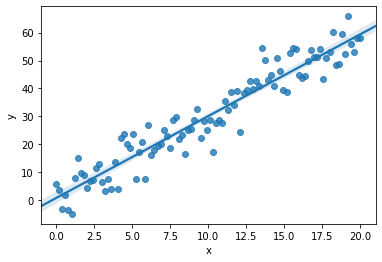

In [4]:
# plot
sns.regplot(df.x, df.y)

In [11]:
# split features and target
X = df[['constant', 'x']]
# fit model and summarize
sm.OLS(y,X).fit().summary()

In [6]:
# define likelihood function
def MLERegression(params):
    intercept, beta, sd = params[0], params[1], params[2] # inputs are guesses at our parameters
    yhat = intercept + beta*x # predictions
    # next, we flip the Bayesian question
    # compute PDF of observed values normally distributed around mean (yhat)
    # with a standard deviation of sd
    negLL = -np.sum( stats.norm.logpdf(y, loc=yhat, scale=sd) )
    # return negative LL
    return(negLL)

In [9]:
# let’s start with some random coefficient guesses and optimize
guess = np.array([5,5,2])
results = minimize(MLERegression, guess, method = 'Nelder-Mead', options={'disp': True})

Optimization terminated successfully.
         Current function value: 292.128416
         Iterations: 111
         Function evaluations: 200


In [10]:
results

 final_simplex: (array([[0.7689675 , 2.96506055, 4.4922065 ],
       [0.7690214 , 2.96505258, 4.49223652],
       [0.76895628, 2.96506083, 4.49222613],
       [0.76903375, 2.96505494, 4.49224128]]), array([292.1284157, 292.1284157, 292.1284157, 292.1284157]))
           fun: 292.12841570113983
       message: 'Optimization terminated successfully.'
          nfev: 200
           nit: 111
        status: 0
       success: True
             x: array([0.7689675 , 2.96506055, 4.4922065 ])